## Exercise 2:

*In this exercise,we work on the skeleton code given on HMMs and fill out the initial and transition probabilities, complete the word_to_ngram(w, n) function, map_ngram_to_integer(ngrams, alphabet), map_integer_to_ngram(l, alphabet) and all the functions below it and atlast find the hamming distance between the n-grams*

In [4]:
import numpy as np
import string
import itertools
import matplotlib.pyplot as plt

In [5]:
# =============================================================================
# A class for a simple discrete HMM with categorial observation model.
# It comes with a Viterbi decoder included.
#
# import it the following way:
#   >>> from pp_2 import hmm
#
# after that, you can create an instance of the class named "foo" e.g. via:
#   >>> M = 4; N = 2
#   >>> foo = hmm(M, N)
# =============================================================================

class HMM:
    def __init__(self, M, N):
        # pi is a vector of size M of the initial probabilities of the latent state
        # T is a matrix of size MxM containing the transition probabilities
        # E is a matrix of size MxN containing the emission probabilities
        # Remember, that M >= N and N is the alphabet size
        self.M = M
        self.N = N
        self.pi = np.ones(M) / M
        self.T = np.identity(M)
        self.E = np.ones([M, N]) / N

    def learn_latent(self, tr):
        # tr is a matrix containing latent state trajectories,
        # it contains the integer sequences created from the sample words.

        init_list = [w[0] for w in tr]
        self.pi = np.asarray([init_list.count(i) / len(init_list) for i in range(self.M)])

        for i in range(tr.shape[0]):
            for j in range(tr.shape[1] - 1):
                s0 = tr[i][j]
                s1 = tr[i][j + 1]
                self.T[s0][s1] += 1

        self.T = (self.T.T / self.T.sum(axis=1)).T
        return

    def decode(self, o):
        # o is a vector representing a sequence of observations in chronological order
        T = len(o)
        T1 = np.zeros([self.M, T])
        T2 = np.zeros([self.M, T])
        x = np.zeros(T, dtype=int)

        # T1 keeps track of the path, that maximizes the observation likelihood
        # T2 keeps track of the last state (t - 1) on the path of T1
        T1[:, 0] = self.pi * self.E[:, o[0]]
        T2[:, 0] = 0

        # Proceed forward through the sequence of observations
        for i in range(1, T):
            T1[:, i] = np.max(T1[:, i - 1] * self.T.T * self.E[np.newaxis, :, o[i]].T, 1)
            T2[:, i] = np.argmax(T1[:, i - 1] * self.T.T, 1)

        # Finalize by going backwards
        x[-1] = np.argmax(T1[:, T - 1])
        for i in reversed(range(1, T)):
            x[i - 1] = T2[x[i], i]

        # return the latent state sequence maximizing the observation likelihood
        return x

In [6]:
def word_to_ngram(w, n):
    return [w[i:i + n] for i in range(len(w) - n + 1)]


def ngram_to_word(ng):
    return ''.join(list(i)[-1] for i in ng)


def map_ngram_to_integer(w, alphabet):
    return [alphabet.index(gram) for gram in w]


def map_integer_to_ngram(w, alphabet):
    return [alphabet[i] for i in w]


def generate_emission_matrix(C, M, N):
    E = (C / C.sum(axis=0)).T
    if N > E.shape[0]:
        E = np.hstack([E, np.zeros((E.shape[0], 1))])
        if M == N or M == N ** 2:
            tmp = np.zeros((1, E.shape[1]))
            tmp[:, -1] = 1
            E = np.vstack([E, tmp])
    if M > N:
        E = np.tile(E.T, reps=N).T
    return E


def sampler(x, pmf):
    return np.random.choice(x, p=pmf)


def sample_observation(x_arr, E):
    y_arr = [sampler(range(0, E.shape[1]), E[x, :]) for x in x_arr]
    return y_arr


def hamming_distance(w1, w2):
    return sum(l1 != l2 for l1, l2 in zip(w1, w2)) / len(w1)


def train_hmm(word_arr, n, C, X, Y):
    M, N = (len(X), len(Y))
    E = generate_emission_matrix(C, M, N)

    ngrams = [word_to_ngram(w, n) for w in word_arr]
    ngrams_encoded = [map_ngram_to_integer(ngram, X) for ngram in ngrams]

    hmm = HMM(M, N)
    hmm.E = E
    hmm.learn_latent(np.asarray(ngrams_encoded))
    return hmm


def distort_words(words_l, E, X):
    observations = []

    for w_padded in words_l:
        ngram_latent = word_to_ngram(w_padded, 1)
        x = map_ngram_to_integer(ngram_latent, X)
        y = sample_observation(x, E)
        observations += [y]
    return observations


def test_hmm(hmm, word_arr, observations, n, X, Y):
    hamm_corrected = 0

    for k in range(len(word_arr)):
        # assign the current words
        w_padded = word_arr[k]
        observation = observations[k]

        # this latent word is to be decoded
        x = word_to_ngram(w_padded, n)

        # mono- and bigrams are different here
        if n == 1:
            w_obs = ''.join(list(i)[-1] for i in x[1:])
            ngrams_corrected = map_integer_to_ngram(hmm.decode(observation), X)
            w_corrected = ''.join(list(i)[-1] for i in ngrams_corrected[1:])
        else:
            w_obs = ''.join(list(i)[-1] for i in x)
            ngrams_corrected = map_integer_to_ngram(hmm.decode(observation[1:]), X)
            w_corrected = ''.join(list(i)[-1] for i in ngrams_corrected)
        hamm_corrected += hamming_distance(w_obs, w_corrected)

        return hamm_corrected / len(word_arr)

*We train and test the monograms and bigrams with the hm*

word len:1
0.0
0.0
word len:2
0.0
0.0
word len:3
0.0
0.0
word len:4
0.0
0.0
word len:5
0.0002603036876355748
0.0
word len:6
0.00017424638438752395
0.0
word len:7
0.0
0.0
word len:8
0.0
0.0
word len:9
0.00036609921288669226
0.0
word len:10
0.0005390835579514825
0.0006738544474393531


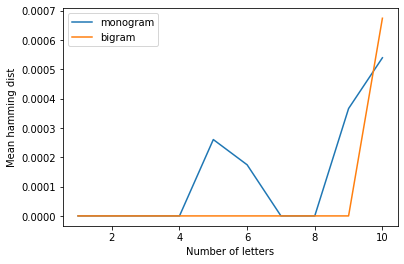

In [7]:
if __name__ == '__main__':
    padding = '_'  # None or the padding symbol as a string, e.g. '_'

    ### PREPARATION ###
    # Read ipm.txt as a string and process as described
    # At the end, you should have an array containing arrays of words with equal length
    with open('ipm.txt', 'r') as file:
        data = file.read()
    all_words = data.split(' ')
    words_by_count = []
    for i in range(1, 11):
        tmp = [w for w in all_words if len(w) == i]
        words_by_count.append(tmp)

    # Read confusion_matrix.csv as a numpy array
    confusion_matrix = np.genfromtxt('confusion_matrix.csv', delimiter=',')
    ###################

    words_by_count = [['_' + w for w in arr] for arr in words_by_count] if padding else words_by_count

    alphabet_y = list(string.ascii_lowercase) + [padding] if padding else list(string.ascii_lowercase)
    alphabet_x_mono = alphabet_y
    alphabet_x_bi = [x + y for x in alphabet_y for y in alphabet_y if y != '_']

    hamming_dist_mono = []
    hamming_dist_bi = []

    for word_len in range(1, 11):
        print(f'word len:{word_len}')
        words_l = words_by_count[word_len - 1]
        hmm_monogram = train_hmm(words_l, n=1, C=confusion_matrix, X=alphabet_x_mono, Y=alphabet_y)
        hmm_bigram = train_hmm(words_l, n=2, C=confusion_matrix, X=alphabet_x_bi, Y=alphabet_y)

        observations = distort_words(words_l, hmm_monogram.E, X=alphabet_x_mono)

        a = test_hmm(hmm_monogram, words_l, observations, n=1, X=alphabet_x_mono, Y=alphabet_y)
        hamming_dist_mono += [a]
        print(a)
        b = test_hmm(hmm_bigram, words_l, observations, n=2, X=alphabet_x_bi, Y=alphabet_y)
        hamming_dist_bi += [b]
        print(b)

    plt.plot(range(1, 11), hamming_dist_mono, label='monogram')
    plt.plot(range(1, 11), hamming_dist_bi, label='bigram')
    plt.ylabel("Mean hamming dist")
    plt.xlabel("Number of letters")
    plt.legend()
    plt.show()
